# Working with Images & Logistic Regression in PyTorch

### Part 3 of "Deep Learning with Pytorch: Zero to GANs"
This tutorial covers the following topics:
    
* Working with images in PyTorch (using the MNIST dataset)
* Splitting a dataset into training, validation, and test sets
* Creating PyTorch models with custom logic by extending the `nn.Module` class
* Interpreting model outputs as probabilities using Softmax and picking predicted labels
* Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification problems
* Setting up a training loop that also evaluates the model using the validation set
* Testing the model manually on randomly picked examples 
* Saving and loading model checkpoints to avoid retraining from scratch

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [5]:
# Download dataset
dataset = MNIST(root='data_MNIST/', download=True)

100.1%Extracting data_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data_MNIST/MNIST/raw
113.5%Extracting data_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data_MNIST/MNIST/raw
100.4%Extracting data_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data_MNIST/MNIST/raw
180.4%Extracting data_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_MNIST/MNIST/raw
Processing...
Done!


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

single data object:  (<PIL.Image.Image image mode=L size=28x28 at 0x7FD148B334F0>, 5)
Label: 5


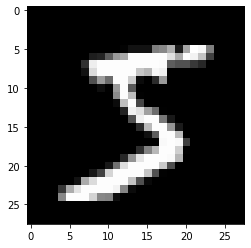

In [12]:
# Visualizing out data
print("single data object: ", dataset[0])

# print the object as a picture (matplotlib graph)
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [13]:
import torchvision.transforms as transforms

In [24]:
# Splitting Dataset
# some information about the dataset
print("the size of the dataset: {}, type: {}".format(len(dataset), type(dataset)))

# split a part of the dataset to be a test dataset (for model evaluation in the end)
test_dataset = MNIST(root='data_MNIST/', train=False)
print("the size of the test dataset: {}, type: {}".format(len(test_dataset), type(test_dataset)))

# transform the data in dataset [from PIL.Image] into tensor form
dataset = MNIST(root='data_MNIST/', train=True, transform=transforms.ToTensor())
img_tensor, label = dataset[0]
print("the shape of transformed training object: ", img_tensor.shape)

the size of the dataset: 60000, type: <class 'torchvision.datasets.mnist.MNIST'>
the size of the test dataset: 10000, type: <class 'torchvision.datasets.mnist.MNIST'>
the shape of transformed training object:  torch.Size([1, 28, 28])


tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


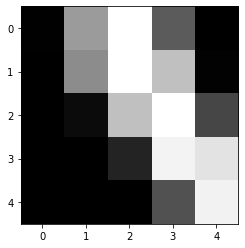

In [27]:
# Understanding & Visualizing a Tensor
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

In [31]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [39]:
# Preparing Data For The Model
# training and talidating sets
train_ds, val_ds = random_split(dataset, [50000, 10000])
print("size of the training set: {}, size of the validation set: {}".format(len(train_ds), len(val_ds)))
print("\n")

# dataloader
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# looking into train_loader
print("train_loader contains: ")
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    break

size of the training set: 50000, size of the validation set: 10000


train_loader contains: 
tensor([6, 4, 8, 9, 9, 6, 6, 9, 2, 1, 9, 4, 8, 4, 9, 9, 4, 9, 8, 6, 0, 5, 7, 3,
        7, 0, 4, 1, 1, 9, 1, 6, 9, 3, 9, 4, 1, 1, 2, 1, 9, 7, 6, 0, 3, 5, 8, 7,
        7, 6, 0, 0, 2, 1, 1, 2, 7, 8, 4, 2, 3, 5, 2, 2, 4, 2, 1, 2, 2, 3, 7, 6,
        2, 0, 6, 4, 6, 2, 2, 1, 3, 9, 1, 5, 3, 1, 0, 0, 3, 4, 2, 9, 6, 2, 9, 9,
        1, 7, 8, 0, 5, 1, 1, 8, 1, 0, 5, 4, 6, 3, 3, 9, 1, 4, 0, 1, 9, 2, 4, 3,
        6, 9, 3, 7, 6, 4, 3, 3])
torch.Size([128, 1, 28, 28])


In [43]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
num_classes = 10

In [44]:
# Model
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    # reshapes the [1, 28. 28] tensors into [1, 784] tensor
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [45]:
# Algorithm
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [48]:
# Calculate Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Evaluation Function
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [49]:
# Results
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3205108642578125, 'val_acc': 0.13795490562915802}

In [50]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9536, val_acc: 0.5863
Epoch [1], val_loss: 1.6860, val_acc: 0.7059
Epoch [2], val_loss: 1.4857, val_acc: 0.7595
Epoch [3], val_loss: 1.3342, val_acc: 0.7842
Epoch [4], val_loss: 1.2175, val_acc: 0.8010


In [51]:
history2 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1257, val_acc: 0.8120
Epoch [1], val_loss: 1.0518, val_acc: 0.8175
Epoch [2], val_loss: 0.9914, val_acc: 0.8233
Epoch [3], val_loss: 0.9409, val_acc: 0.8274
Epoch [4], val_loss: 0.8983, val_acc: 0.8311
Epoch [5], val_loss: 0.8618, val_acc: 0.8338
Epoch [6], val_loss: 0.8301, val_acc: 0.8359
Epoch [7], val_loss: 0.8024, val_acc: 0.8388
Epoch [8], val_loss: 0.7779, val_acc: 0.8419
Epoch [9], val_loss: 0.7561, val_acc: 0.8441


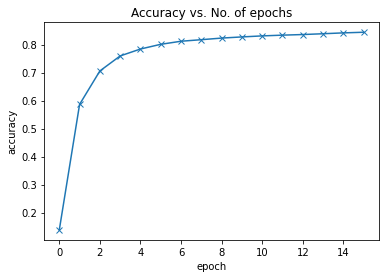

In [52]:
# Visualize Results
history = [result0] + history1 + history2
accuracies = [result['val_acc'] for result in history]

plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');